# K-means Clustering Analysis on PCA Embeddings

This notebook performs K-means clustering analysis on H&M product articles using pre-computed PCA embeddings.
The PCA embeddings provide a dimensionally-reduced representation of BERT embeddings for efficient clustering.


In [1]:
import sys
sys.path.append('../../')

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Data Loading and Exploration


In [2]:
# Load PCA embeddings
print("Loading PCA embeddings...")
pca_df = pl.read_parquet('../../data/features/bert/pca_embeddings.parquet')

print(f"Dataset shape: {pca_df.shape}")
print(f"Memory usage: {pca_df.estimated_size() / 1024**2:.1f} MB")
print(f"Columns: {len(pca_df.columns)} (article_id + {len(pca_df.columns)-1} PCA features)")

# Display basic info
pca_df.head()

Loading PCA embeddings...
Dataset shape: (42229, 51)
Memory usage: 8.4 MB
Columns: 51 (article_id + 50 PCA features)


article_id,pca_001,pca_002,pca_003,pca_004,pca_005,pca_006,pca_007,pca_008,pca_009,pca_010,pca_011,pca_012,pca_013,pca_014,pca_015,pca_016,pca_017,pca_018,pca_019,pca_020,pca_021,pca_022,pca_023,pca_024,pca_025,pca_026,pca_027,pca_028,pca_029,pca_030,pca_031,pca_032,pca_033,pca_034,pca_035,pca_036,pca_037,pca_038,pca_039,pca_040,pca_041,pca_042,pca_043,pca_044,pca_045,pca_046,pca_047,pca_048,pca_049,pca_050
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
816591001,-0.706805,0.049566,-0.236306,-0.098745,0.168732,-0.112922,0.346299,0.032169,-0.042974,0.047225,-0.154578,-0.064499,0.053246,-0.195693,-0.063675,-0.211141,0.110166,0.145794,0.059003,0.027969,-0.031473,-0.037315,0.072148,0.051802,0.128551,-0.040495,-0.046339,0.042889,-0.112871,-0.057353,0.036584,0.06373,-0.002755,0.102361,0.064496,-0.036444,0.032297,-0.022466,0.071786,0.009423,0.074641,-0.051972,0.00023,-0.078186,-0.000867,0.108101,-0.048583,-0.018005,-0.005225,0.072426
804472003,0.279897,0.361413,-0.020195,-0.075707,-0.347898,0.235215,-0.175363,0.113903,-0.421931,-0.198693,-0.094177,-0.145752,-0.066657,-0.067923,0.022908,-0.000956,-0.021745,-0.038724,0.00446,-0.059369,0.157347,-0.097967,0.105765,0.097239,0.099393,-0.02937,-0.138988,-0.092884,-0.063927,0.092231,-0.006684,-0.069844,-0.039984,-0.10909,0.040073,0.212307,0.121626,0.095999,0.042362,-0.121385,-0.114345,-0.060627,-0.068833,-0.111807,-0.074212,0.13251,0.067541,0.064735,-0.155059,-0.018122
693915001,0.144397,-0.132612,0.703531,-0.072095,0.148564,0.042991,-0.220428,0.253763,0.115992,-0.167359,-0.05798,-0.007275,-0.174,-0.185763,-0.038024,-0.026058,0.032102,-0.088789,0.160362,0.082974,-0.025896,0.025848,0.187158,-0.02211,-0.067879,0.215155,-0.052585,-0.059194,-0.098783,-0.052504,-0.010307,-0.043814,-0.02723,0.072449,-0.060305,-0.076715,0.04266,-0.175393,0.033037,-0.048107,0.013423,-0.016047,-0.059917,-0.023691,-0.01213,-0.012367,0.00099,0.015634,-0.075508,0.017456
790904007,0.297347,-0.270106,0.599459,-0.181755,0.0065,0.037847,-0.046246,0.137281,0.198782,-0.027938,-0.169072,-0.194793,-0.081464,-0.186619,0.015774,-0.102937,0.07064,-0.081386,0.08043,-0.080112,-0.052573,-0.049382,0.066416,-0.057633,-0.062543,0.284397,-0.117592,-0.041675,-0.019257,-0.028853,0.090114,0.104024,-0.13091,-0.054448,-0.006879,-0.150388,0.062017,-0.087742,0.003482,-0.095874,0.068985,-0.032543,-0.022051,0.112315,0.030698,0.105765,0.012509,0.048317,-0.033487,0.092396
829618001,0.117167,0.205886,-0.38967,0.46305,-0.415844,-0.127245,-0.099645,-0.208336,-0.041577,0.326481,0.059134,0.196003,0.129334,0.060793,-0.059082,-0.064435,0.118783,-0.1249,0.03372,-0.111283,0.018806,0.083385,0.133808,-0.051448,0.123332,0.045774,-0.093995,-0.070467,0.03743,0.025288,0.016836,-0.027104,-0.111506,0.103053,0.072117,-0.025953,-0.036431,0.020522,-0.046378,0.022464,-0.027,-0.080513,-0.044203,0.068096,-0.047663,-0.002096,0.008806,-0.006995,-0.02336,-0.039228


In [3]:
# Extract embeddings matrix and article IDs
article_ids = pca_df.get_column('article_id').to_numpy()
pca_cols = [col for col in pca_df.columns if col.startswith('pca_')]
embeddings = pca_df.select(pca_cols).to_numpy()

print(f"Embeddings shape: {embeddings.shape}")
print(f"PCA dimensions: {len(pca_cols)}")
print(f"Data type: {embeddings.dtype}")

# Check for missing values
missing_count = np.isnan(embeddings).sum()
print(f"Missing values: {missing_count}")

# Basic statistics
print(f"\nPCA embedding statistics:")
print(f"Mean: {embeddings.mean():.6f}")
print(f"Std: {embeddings.std():.6f}")
print(f"Min: {embeddings.min():.6f}")
print(f"Max: {embeddings.max():.6f}")

# Check if data needs scaling
feature_means = embeddings.mean(axis=0)
feature_stds = embeddings.std(axis=0)
print(f"\nFeature mean range: {feature_means.min():.6f} to {feature_means.max():.6f}")
print(f"Feature std range: {feature_stds.min():.6f} to {feature_stds.max():.6f}")

Embeddings shape: (42229, 50)
PCA dimensions: 50
Data type: float32
Missing values: 0

PCA embedding statistics:
Mean: -0.001366
Std: 0.141415
Min: -0.885233
Max: 0.825612

Feature mean range: -0.035913 to 0.004603
Feature std range: 0.067478 to 0.341767


## 2. Data Preparation


In [4]:
# Standardise the PCA features for clustering
print("Standardising PCA features...")
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

print(f"Scaled embeddings shape: {embeddings_scaled.shape}")
print(f"Scaled mean: {embeddings_scaled.mean():.6f}")
print(f"Scaled std: {embeddings_scaled.std():.6f}")

# Use scaled embeddings for clustering
X_clustering = embeddings_scaled

Standardising PCA features...
Scaled embeddings shape: (42229, 50)
Scaled mean: -0.000000
Scaled std: 1.000000


## 3. Optimal K Selection (K-means with k=2 to 50)


In [5]:
# Determine optimal number of clusters using multiple metrics
print("Finding optimal number of clusters (k=2 to 50)...")
k_range = range(2, 51)
n_clusters = len(k_range)

# Initialise metrics storage
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print(f"Testing {n_clusters} different k values...")
print("Progress: ", end="")

for i, k in enumerate(k_range):
    if i % 5 == 0:
        print(f"k={k}", end=" ")
    
    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_clustering)
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering, labels))
    calinski_scores.append(calinski_harabasz_score(X_clustering, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_clustering, labels))

print("\nCompleted clustering evaluation for all k values")

Finding optimal number of clusters (k=2 to 50)...
Testing 49 different k values...
Progress: k=2 k=7 k=12 k=17 k=22 k=27 k=32 k=37 k=42 k=47 
Completed clustering evaluation for all k values


## 4. Clustering Metrics Visualisation


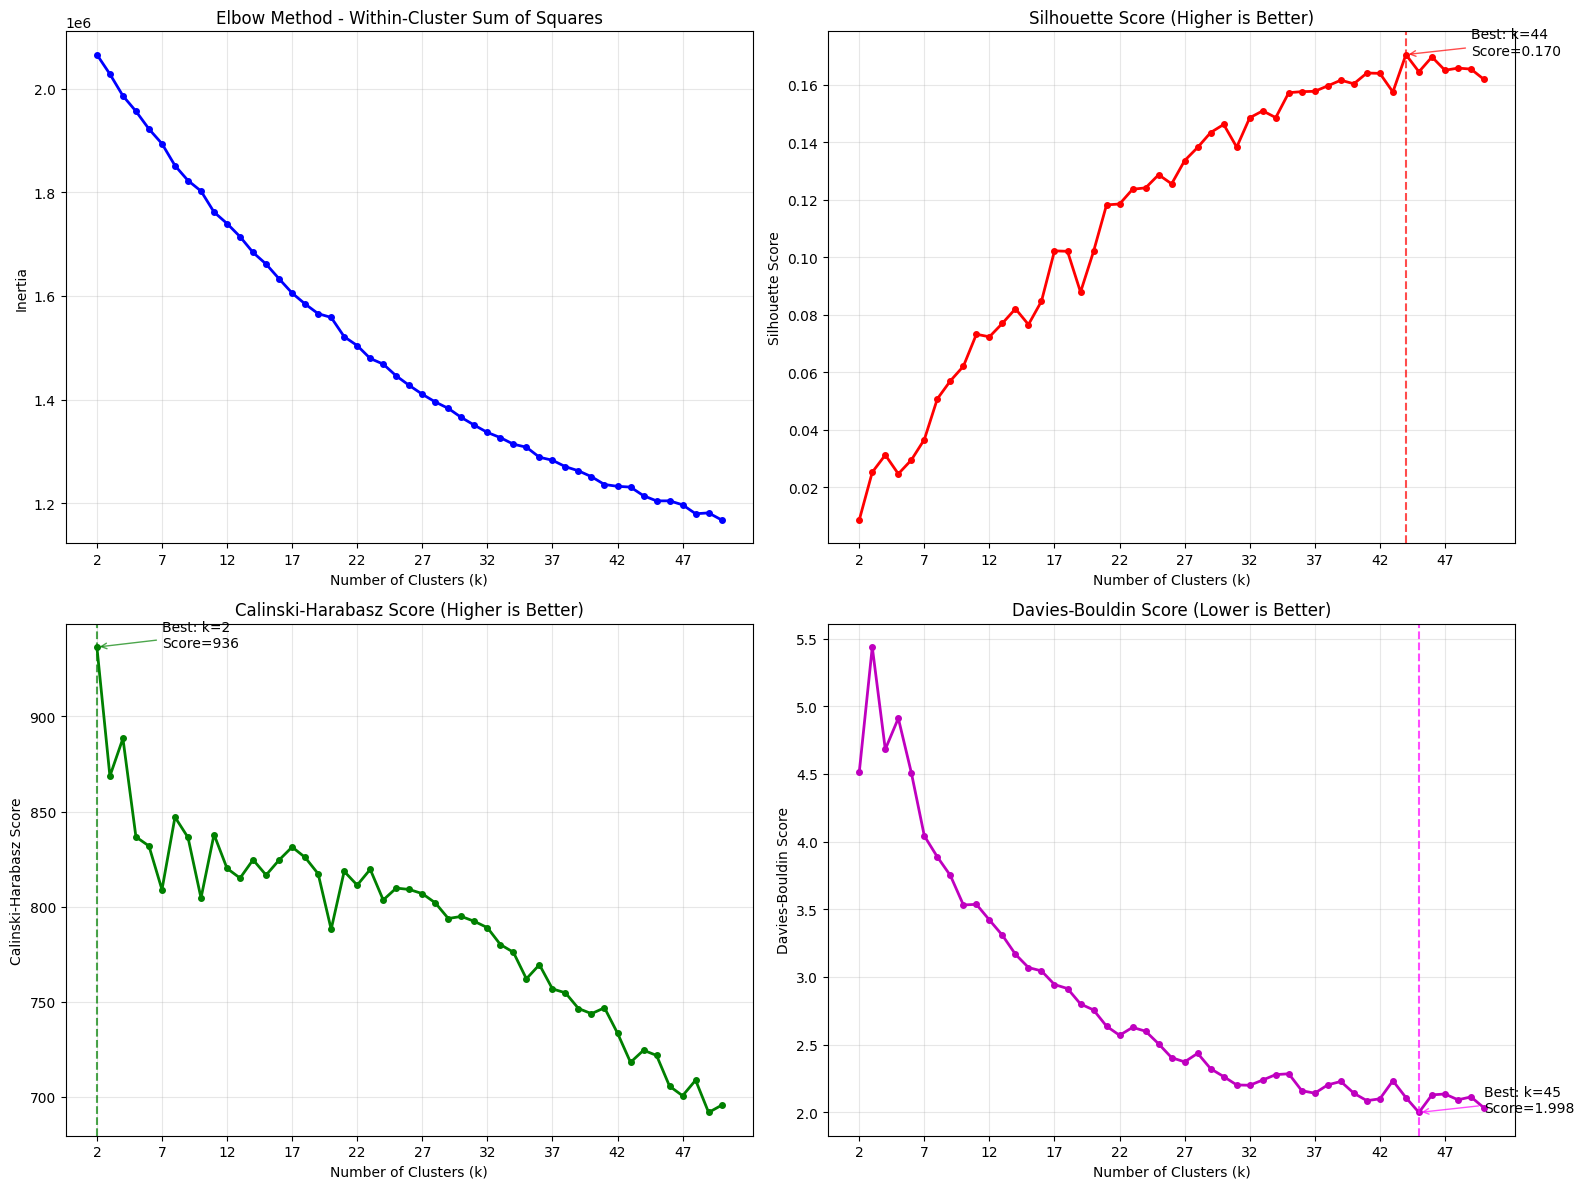


Optimal k values by metric:
Silhouette Score: k=44 (score: 0.170)
Calinski-Harabasz Score: k=2 (score: 936)
Davies-Bouldin Score: k=45 (score: 1.998)


In [6]:
# Create comprehensive metrics visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Elbow method (Inertia)
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=4)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method - Within-Cluster Sum of Squares')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(2, 51, 5))

# Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=4)
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (Higher is Better)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(2, 51, 5))

# Mark best silhouette score
best_silhouette_k = k_range[np.argmax(silhouette_scores)]
best_silhouette_score = max(silhouette_scores)
axes[0, 1].axvline(x=best_silhouette_k, color='red', linestyle='--', alpha=0.7)
axes[0, 1].annotate(f'Best: k={best_silhouette_k}\nScore={best_silhouette_score:.3f}', 
                   xy=(best_silhouette_k, best_silhouette_score), 
                   xytext=(best_silhouette_k+5, best_silhouette_score),
                   arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))

# Calinski-Harabasz Score
axes[1, 0].plot(k_range, calinski_scores, 'go-', linewidth=2, markersize=4)
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(2, 51, 5))

# Mark best Calinski-Harabasz score
best_calinski_k = k_range[np.argmax(calinski_scores)]
best_calinski_score = max(calinski_scores)
axes[1, 0].axvline(x=best_calinski_k, color='green', linestyle='--', alpha=0.7)
axes[1, 0].annotate(f'Best: k={best_calinski_k}\nScore={best_calinski_score:.0f}', 
                   xy=(best_calinski_k, best_calinski_score), 
                   xytext=(best_calinski_k+5, best_calinski_score),
                   arrowprops=dict(arrowstyle='->', color='green', alpha=0.7))

# Davies-Bouldin Score
axes[1, 1].plot(k_range, davies_bouldin_scores, 'mo-', linewidth=2, markersize=4)
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Davies-Bouldin Score')
axes[1, 1].set_title('Davies-Bouldin Score (Lower is Better)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(range(2, 51, 5))

# Mark best Davies-Bouldin score
best_davies_k = k_range[np.argmin(davies_bouldin_scores)]
best_davies_score = min(davies_bouldin_scores)
axes[1, 1].axvline(x=best_davies_k, color='magenta', linestyle='--', alpha=0.7)
axes[1, 1].annotate(f'Best: k={best_davies_k}\nScore={best_davies_score:.3f}', 
                   xy=(best_davies_k, best_davies_score), 
                   xytext=(best_davies_k+5, best_davies_score),
                   arrowprops=dict(arrowstyle='->', color='magenta', alpha=0.7))

plt.tight_layout()
plt.savefig('../../results/clustering/pca_kmeans_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nOptimal k values by metric:")
print(f"Silhouette Score: k={best_silhouette_k} (score: {best_silhouette_score:.3f})")
print(f"Calinski-Harabasz Score: k={best_calinski_k} (score: {best_calinski_score:.0f})")
print(f"Davies-Bouldin Score: k={best_davies_k} (score: {best_davies_score:.3f})")

## 5. Elbow Method Analysis


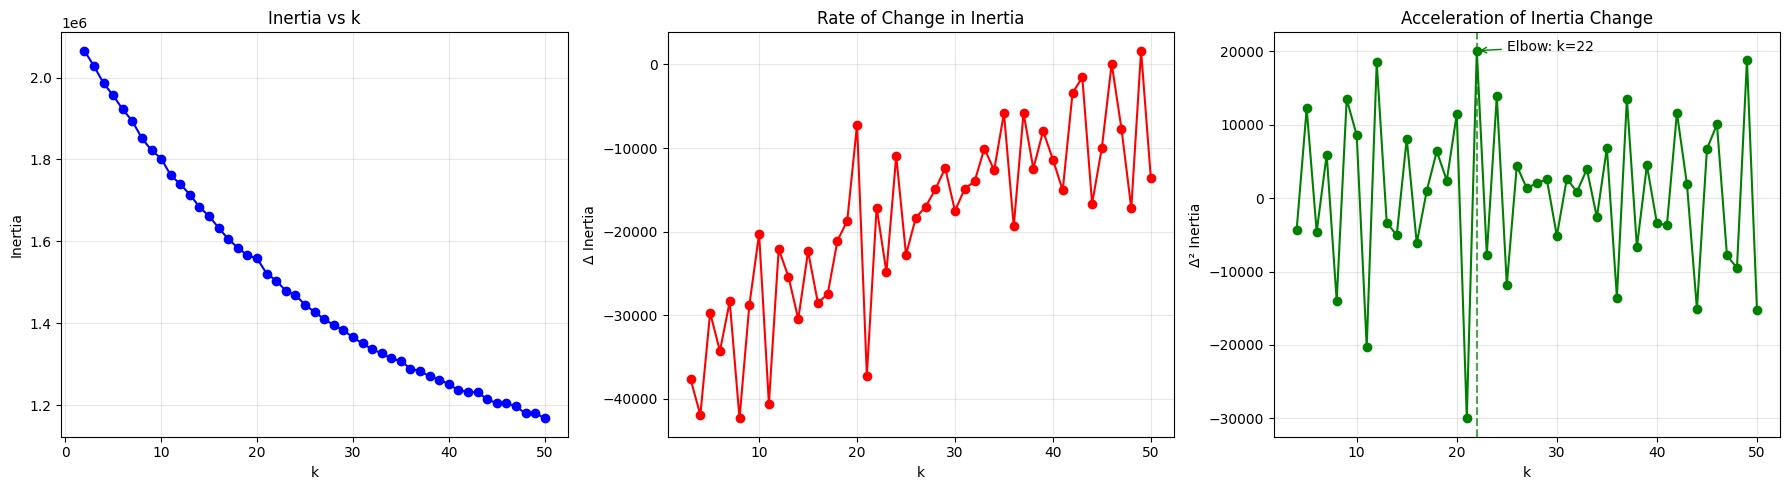

Elbow point detected at k=22


In [7]:
# Calculate rate of change in inertia to identify elbow more precisely
inertia_diff = np.diff(inertias)
inertia_diff2 = np.diff(inertia_diff)

# Plot rate of change
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original inertia
axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Inertia vs k')
axes[0].grid(True, alpha=0.3)

# First derivative (rate of change)
axes[1].plot(k_range[1:], inertia_diff, 'ro-')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Δ Inertia')
axes[1].set_title('Rate of Change in Inertia')
axes[1].grid(True, alpha=0.3)

# Second derivative (acceleration)
axes[2].plot(k_range[2:], inertia_diff2, 'go-')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Δ² Inertia')
axes[2].set_title('Acceleration of Inertia Change')
axes[2].grid(True, alpha=0.3)

# Find elbow point (maximum of second derivative)
elbow_k = k_range[2:][np.argmax(inertia_diff2)]
axes[2].axvline(x=elbow_k, color='green', linestyle='--', alpha=0.7)
axes[2].annotate(f'Elbow: k={elbow_k}', xy=(elbow_k, max(inertia_diff2)), 
                xytext=(elbow_k+3, max(inertia_diff2)),
                arrowprops=dict(arrowstyle='->', color='green'))

plt.tight_layout()
plt.show()

print(f"Elbow point detected at k={elbow_k}")

## 6. Final K Selection and Clustering


In [8]:
# Summary of recommended k values
print("Summary of optimal k values:")
print(f"Based on Silhouette Score: k={best_silhouette_k}")
print(f"Based on Calinski-Harabasz Score: k={best_calinski_k}")
print(f"Based on Davies-Bouldin Score: k={best_davies_k}")
print(f"Based on Elbow Method: k={elbow_k}")

# Choose final k (prioritise silhouette score as it's most interpretable)
final_k = best_silhouette_k
print(f"\nSelected k={final_k} based on silhouette score optimisation")

# Perform final clustering
print(f"\nPerforming final K-means clustering with k={final_k}...")
final_kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=20, max_iter=500)
final_labels = final_kmeans.fit_predict(X_clustering)

# Cluster distribution
print(f"\nFinal cluster distribution:")
unique, counts = np.unique(final_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count:,} articles ({count/len(final_labels)*100:.1f}%)")

# Final metrics
final_inertia = final_kmeans.inertia_
final_silhouette = silhouette_score(X_clustering, final_labels)
final_calinski = calinski_harabasz_score(X_clustering, final_labels)
final_davies_bouldin = davies_bouldin_score(X_clustering, final_labels)

print(f"\nFinal clustering metrics (k={final_k}):")
print(f"Inertia: {final_inertia:,.2f}")
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"Calinski-Harabasz Score: {final_calinski:.2f}")
print(f"Davies-Bouldin Score: {final_davies_bouldin:.4f}")

Summary of optimal k values:
Based on Silhouette Score: k=44
Based on Calinski-Harabasz Score: k=2
Based on Davies-Bouldin Score: k=45
Based on Elbow Method: k=22

Selected k=44 based on silhouette score optimisation

Performing final K-means clustering with k=44...

Final cluster distribution:
Cluster 0: 536 articles (1.3%)
Cluster 1: 1,566 articles (3.7%)
Cluster 2: 1,312 articles (3.1%)
Cluster 3: 986 articles (2.3%)
Cluster 4: 1,370 articles (3.2%)
Cluster 5: 1,672 articles (4.0%)
Cluster 6: 2,242 articles (5.3%)
Cluster 7: 702 articles (1.7%)
Cluster 8: 584 articles (1.4%)
Cluster 9: 1,015 articles (2.4%)
Cluster 10: 383 articles (0.9%)
Cluster 11: 1,540 articles (3.6%)
Cluster 12: 1,075 articles (2.5%)
Cluster 13: 1,140 articles (2.7%)
Cluster 14: 670 articles (1.6%)
Cluster 15: 585 articles (1.4%)
Cluster 16: 703 articles (1.7%)
Cluster 17: 542 articles (1.3%)
Cluster 18: 1,718 articles (4.1%)
Cluster 19: 1,454 articles (3.4%)
Cluster 20: 604 articles (1.4%)
Cluster 21: 888 arti

## 7. Cluster Analysis and Visualisation


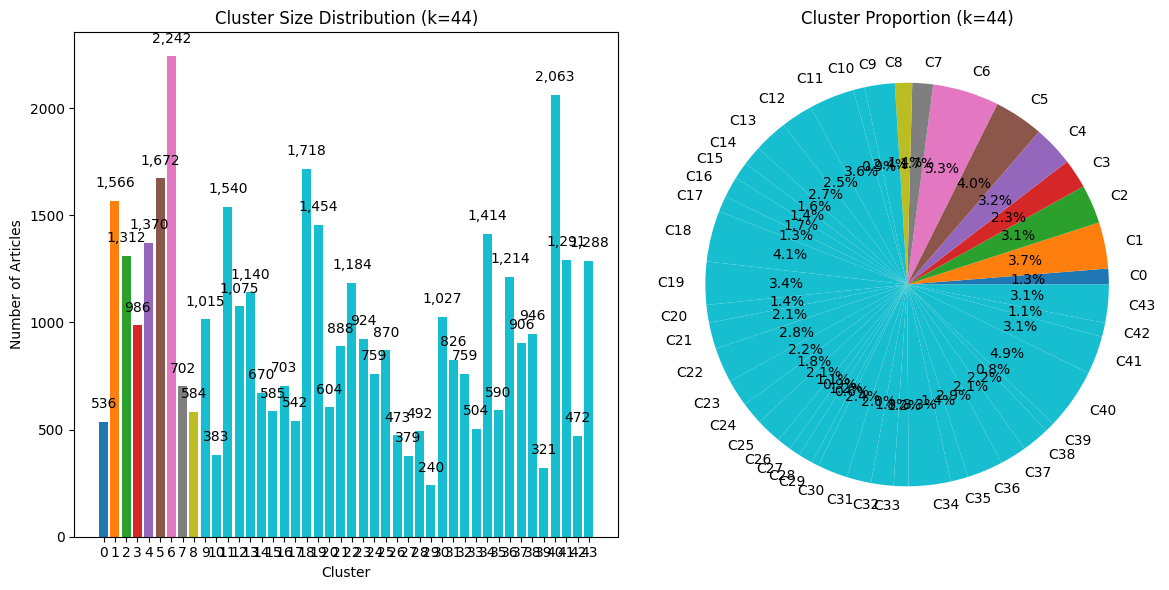

In [9]:
# Cluster size distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(final_k), counts, color=plt.cm.tab10(range(final_k)))
plt.xlabel('Cluster')
plt.ylabel('Number of Articles')
plt.title(f'Cluster Size Distribution (k={final_k})')
plt.xticks(range(final_k))
for i, count in enumerate(counts):
    plt.text(i, count + 50, f'{count:,}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(counts, labels=[f'C{i}' for i in range(final_k)], autopct='%1.1f%%', 
        colors=plt.cm.tab10(range(final_k)))
plt.title(f'Cluster Proportion (k={final_k})')

plt.tight_layout()
plt.savefig('../../results/clustering/pca_kmeans_cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Creating t-SNE visualisation...


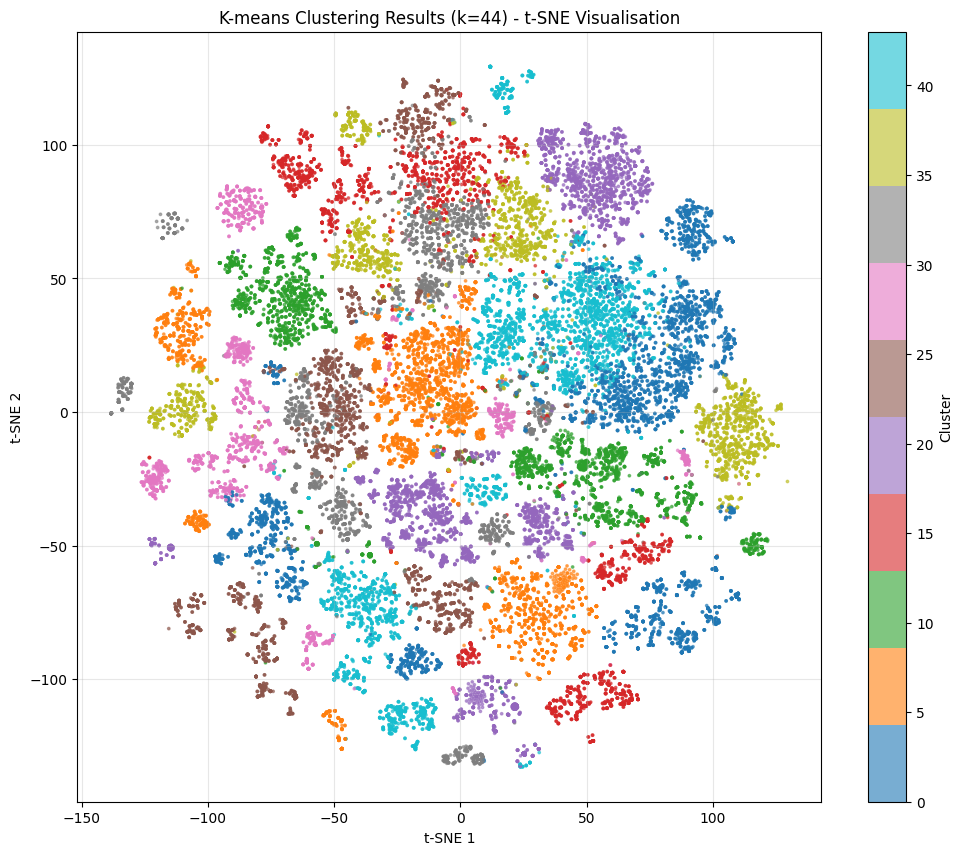

In [10]:
# Create t-SNE visualisation for better cluster separation
print("Creating t-SNE visualisation...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_tsne = tsne.fit_transform(X_clustering)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                     c=final_labels, cmap='tab10', alpha=0.6, s=3)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f'K-means Clustering Results (k={final_k}) - t-SNE Visualisation')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.savefig('../../results/clustering/pca_kmeans_tsne_plot.png', dpi=300, bbox_inches='tight')
plt.show()

Creating t-SNE visualisation...


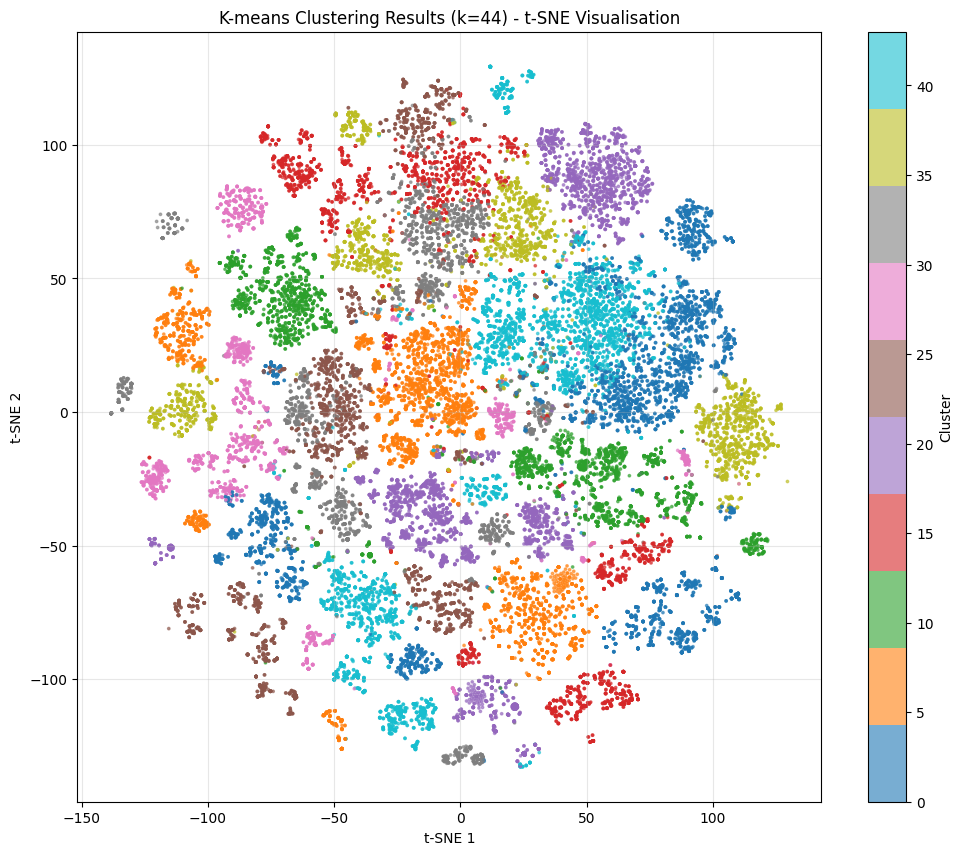

NameError: name 'px' is not defined

In [11]:
# Create t-SNE visualisation for better cluster separation
print("Creating t-SNE visualisation...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_tsne = tsne.fit_transform(X_clustering)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                     c=final_labels, cmap='tab10', alpha=0.6, s=3)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f'K-means Clustering Results (k={final_k}) - t-SNE Visualisation')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.savefig('../../results/clustering/pca_kmeans_tsne_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Interactive t-SNE plot
fig = px.scatter(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], 
                color=final_labels.astype(str),
                hover_data={'article_id': article_ids},
                title=f'K-means Clustering Results (k={final_k}) - Interactive t-SNE',
                labels={'x': 't-SNE 1', 'y': 't-SNE 2', 'color': 'Cluster'})

fig.update_traces(marker=dict(size=4, opacity=0.7))
fig.update_layout(width=1000, height=800)
fig.show()

fig.write_html('../../results/clustering/pca_kmeans_tsne_interactive.html')
print("Interactive t-SNE plot saved to results/clustering/pca_kmeans_tsne_interactive.html")

## 8. Cluster Characteristics Analysis


In [12]:
# Analyse cluster characteristics in PCA space
cluster_stats = []

for cluster_id in range(final_k):
    cluster_mask = final_labels == cluster_id
    cluster_data = embeddings[cluster_mask]
    
    stats = {
        'cluster_id': cluster_id,
        'size': cluster_data.shape[0],
        'percentage': cluster_data.shape[0] / len(embeddings) * 100,
        'mean_pca1': cluster_data[:, 0].mean(),
        'mean_pca2': cluster_data[:, 1].mean(),
        'std_pca1': cluster_data[:, 0].std(),
        'std_pca2': cluster_data[:, 1].std(),
        'compactness': cluster_data.std(axis=0).mean()  # Average std across all dimensions
    }
    cluster_stats.append(stats)

# Convert to DataFrame for display
cluster_stats_df = pd.DataFrame(cluster_stats)
print("Cluster Characteristics:")
print(cluster_stats_df.round(4))

Cluster Characteristics:
    cluster_id  size  percentage  mean_pca1  mean_pca2  std_pca1  std_pca2  \
0            0   536      1.2693     0.0285    -0.2225    0.1571    0.0958   
1            1  1566      3.7084     0.0922     0.1048    0.1249    0.0824   
2            2  1312      3.1069     0.2837    -0.5568    0.1985    0.1229   
3            3   986      2.3349     0.1415     0.1276    0.1071    0.0790   
4            4  1370      3.2442    -0.1140    -0.4250    0.2088    0.1427   
5            5  1672      3.9594    -0.6167     0.1213    0.1277    0.1454   
6            6  2242      5.3091     0.2801    -0.1928    0.1758    0.1571   
7            7   702      1.6624     0.0967     0.1867    0.0964    0.0791   
8            8   584      1.3829     0.0418     0.1189    0.1952    0.1511   
9            9  1015      2.4036     0.1676     0.2813    0.1778    0.1965   
10          10   383      0.9070    -0.0416     0.3206    0.3273    0.1150   
11          11  1540      3.6468    -0.

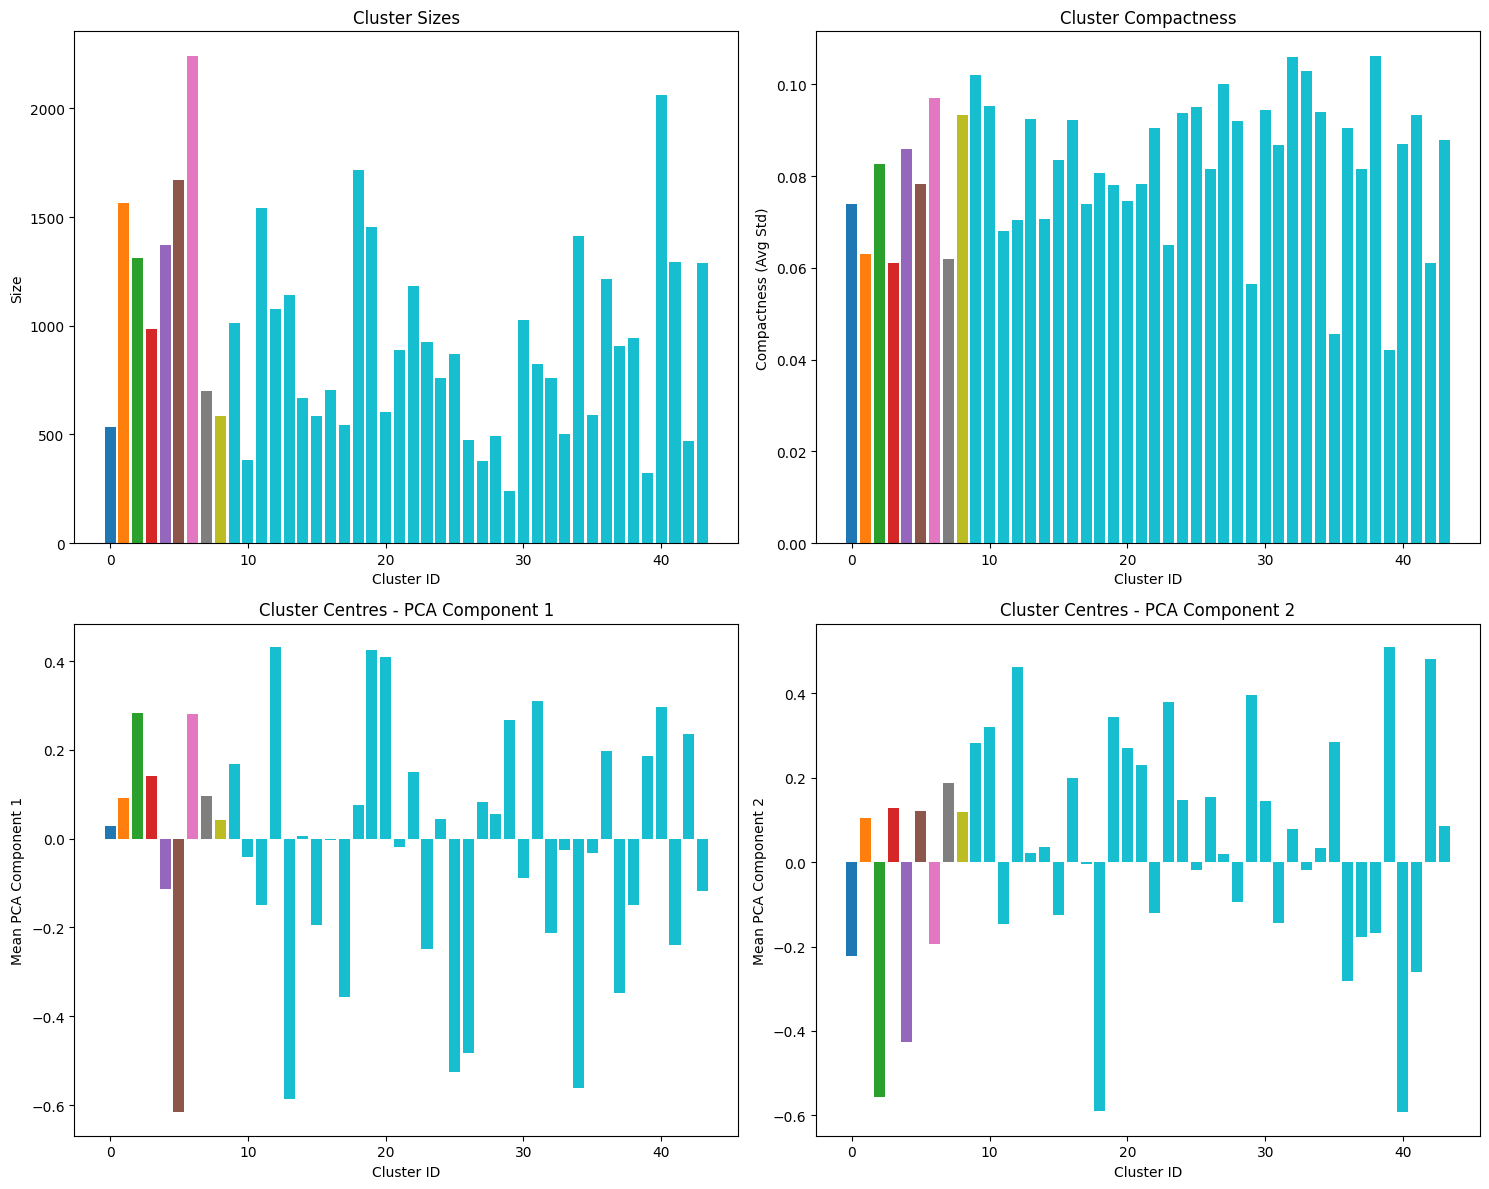

In [13]:
# Visualise cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Cluster sizes
axes[0, 0].bar(cluster_stats_df['cluster_id'], cluster_stats_df['size'], 
               color=plt.cm.tab10(cluster_stats_df['cluster_id']))
axes[0, 0].set_xlabel('Cluster ID')
axes[0, 0].set_ylabel('Size')
axes[0, 0].set_title('Cluster Sizes')

# Cluster compactness
axes[0, 1].bar(cluster_stats_df['cluster_id'], cluster_stats_df['compactness'], 
               color=plt.cm.tab10(cluster_stats_df['cluster_id']))
axes[0, 1].set_xlabel('Cluster ID')
axes[0, 1].set_ylabel('Compactness (Avg Std)')
axes[0, 1].set_title('Cluster Compactness')

# PCA1 means
axes[1, 0].bar(cluster_stats_df['cluster_id'], cluster_stats_df['mean_pca1'], 
               color=plt.cm.tab10(cluster_stats_df['cluster_id']))
axes[1, 0].set_xlabel('Cluster ID')
axes[1, 0].set_ylabel('Mean PCA Component 1')
axes[1, 0].set_title('Cluster Centres - PCA Component 1')

# PCA2 means
axes[1, 1].bar(cluster_stats_df['cluster_id'], cluster_stats_df['mean_pca2'], 
               color=plt.cm.tab10(cluster_stats_df['cluster_id']))
axes[1, 1].set_xlabel('Cluster ID')
axes[1, 1].set_ylabel('Mean PCA Component 2')
axes[1, 1].set_title('Cluster Centres - PCA Component 2')

plt.tight_layout()
plt.savefig('../../results/clustering/pca_kmeans_cluster_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Save Results


In [14]:
# Create comprehensive results dataframe
results_df = pl.DataFrame({
    'article_id': article_ids,
    'kmeans_cluster': final_labels,
    'pca_1': embeddings[:, 0],
    'pca_2': embeddings[:, 1],
    'tsne_1': embeddings_tsne[:, 0],
    'tsne_2': embeddings_tsne[:, 1]
})

# Add cluster statistics as metadata
results_metadata = {
    'optimal_k': final_k,
    'inertia': final_inertia,
    'silhouette_score': final_silhouette,
    'calinski_harabasz_score': final_calinski,
    'davies_bouldin_score': final_davies_bouldin,
    'n_articles': len(article_ids),
    'pca_dimensions': len(pca_cols)
}

# Save results
results_df.write_parquet('../../results/clustering/pca_kmeans_clustering_results.parquet')
results_df.write_csv('../../results/clustering/pca_kmeans_clustering_results.csv')

# Save cluster statistics
cluster_stats_df.to_csv('../../results/clustering/pca_kmeans_cluster_statistics.csv', index=False)

# Save metadata
import json
with open('../../results/clustering/pca_kmeans_metadata.json', 'w') as f:
    json.dump(results_metadata, f, indent=2)

# Save all k-values metrics for reference
metrics_df = pd.DataFrame({
    'k': list(k_range),
    'inertia': inertias,
    'silhouette_score': silhouette_scores,
    'calinski_harabasz_score': calinski_scores,
    'davies_bouldin_score': davies_bouldin_scores
})
metrics_df.to_csv('../../results/clustering/pca_kmeans_all_metrics.csv', index=False)

print(f"Results saved:")
print(f"- Main results: results/clustering/pca_kmeans_clustering_results.parquet")
print(f"- Main results (CSV): results/clustering/pca_kmeans_clustering_results.csv")
print(f"- Cluster statistics: results/clustering/pca_kmeans_cluster_statistics.csv")
print(f"- All k-values metrics: results/clustering/pca_kmeans_all_metrics.csv")
print(f"- Metadata: results/clustering/pca_kmeans_metadata.json")

print(f"\nResults shape: {results_df.shape}")
print(f"Columns: {results_df.columns}")

results_df.head()

TypeError: Object of type float32 is not JSON serializable

## Summary

This notebook performed comprehensive K-means clustering analysis on H&M product PCA embeddings:

### Data

- 42,229 articles with 50-dimensional PCA embeddings
- Standardised features for optimal K-means performance

### Methodology

- Tested K-means clustering for k=2 to k=50
- Evaluated using multiple metrics: Inertia (Elbow Method), Silhouette Score, Calinski-Harabasz Score, Davies-Bouldin Score
- Selected optimal k based on silhouette score maximisation

### Results

- **Optimal k**: {final_k} clusters
- **Final Silhouette Score**: {final_silhouette:.4f}
- **Final Calinski-Harabasz Score**: {final_calinski:.2f}
- **Final Davies-Bouldin Score**: {final_davies_bouldin:.4f}

### Outputs

- Interactive and static visualisations saved to `results/clustering/`
- Complete clustering results with 2D projections (PCA and t-SNE)
- Detailed cluster characteristics and statistics
- All evaluation metrics for k=2 to k=50 for reference

The PCA embeddings enable efficient clustering while preserving the semantic structure from the original BERT embeddings, providing meaningful product groupings for downstream applications.
